In [3]:
# 加载必要的包
library(ggplot2)
library(dplyr)
library(viridis)
library(scales)  # 用于格式化坐标轴标签
# 加载必要的包
library(gridExtra)  # 用于调整图例

In [6]:
df1 = read.csv('../../SCST/input/LRs/0915/D1-3.txt', sep='\t')
df2 = read.csv('../../SCST/input/LRs/0915/D5-15.txt', sep='\t')
df3 = read.csv('../../SCST/input/LRs/0915/D18-21.txt', sep='\t')

In [7]:
df1$stage = '1-3DAP'
df2$stage = '5-15DAP'
df3$stage = '18-21DAP'

In [8]:
combined_df <- rbind(df1, df2, df3)

In [9]:
write.csv(combined_df, '../../SCST/input/LRs/0915/D1-21_concat_1201.csv')

In [11]:
combined_df = read.csv('../../SCST/input/LRs/0915/select/D1-21_select_filter_0928.txt', sep='\t')
# head(combined_df, 2)

In [14]:
lr_pair = read.csv('../../SCST/input/LRs/0915//select//pair_list_0928.txt')
# head(lr_pair, 2)

#### 单个版本

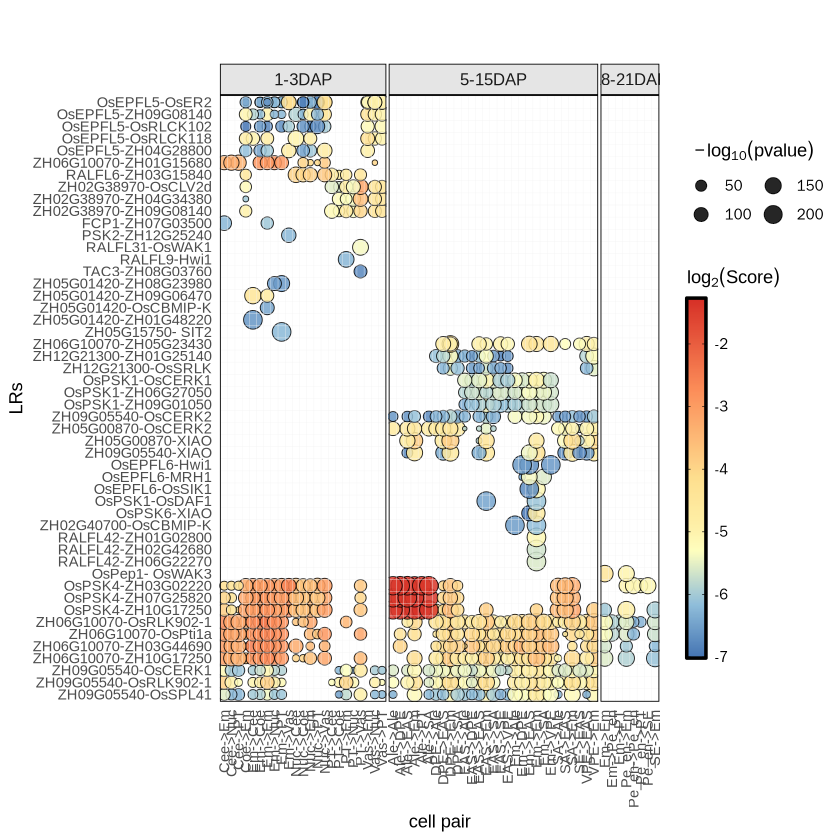

In [20]:
data = combined_df
data$gene_pair = paste(data$Ligands.gene.symbol, data$Receptors.gene.symbol, sep='-')
data$score = log2(data$Score)
data$log_pvalue <- -log10(data$Pvalue)

data = data[c('stage', 'Cell_pair', 'gene_pair', 'Pvalue', 'log_pvalue', 'score')]
colnames(data) = c('stage', 'cell_pair', 'gene_pair', 'pvalue', 'log_pvalue', 'score')
data[data$log_pvalue == Inf, ]$log_pvalue <- 220

data$stage <- factor(data$stage, levels = c('1-3DAP', '5-15DAP', '18-21DAP'))
# data$cell_pair <- factor(data$cell_pair, levels = c('Ale->SA', 'SA->Ale', 'EAS->Em', 'Em->EAS'))
# data$cell_pair <- factor(data$cell_pair, levels = unique(sort$cell_pair_sorted))
data$gene_pair <- factor(data$gene_pair, levels = rev(unique(lr_pair$LR_pair)))
# data <- data[order(data$cell_pair), ]
data <- data[order(data$stage), ]
data <- data[order(data$gene_pair), ]

lrs_dotplots(data, paste('../../SCST/input/LRs/0915/select/', 'D1-21_select_0928_tmp.pdf'))


In [17]:
# 自定义红蓝颜色梯度
lrs_dotplots <- function(data, outpdf) {
    red_blue_palette <- colorRampPalette(c("#4575B4", "#91BFDB", "#FFFFBF", "#FEE090", "#FC8D59", "#D73027"))
    # red_blue_palette <- colorRampPalette(c("#D73027", "#FC8D59", "#FEE090", "#FFFFBF", "#91BFDB", "#4575B4" ))
    midpoint <- median(data$score)  # 计算score的中位数作为颜色中点

# 创建气泡图
    p <- ggplot(data, aes(x = cell_pair, y = gene_pair)) +
      geom_point(aes(size = log_pvalue, fill = score), 
                 shape = 21, 
                 color = "black", 
                 stroke = 0.4, 
                 alpha = 0.85) +
          # 气泡大小比例尺（表示-log10(pvalues)）
          scale_size_continuous(
            name = expression(-log[10](pvalue)),
            range = c(1, 5),
            breaks = pretty_breaks(5)(data$log_pvalue),
            guide = guide_legend(
              override.aes = list(fill = "black"),
              title.position = "top",
              title.hjust = 0.5,
              order = 1,
              nrow = 2
            )
          ) +
          # 红蓝颜色比例尺（表示表达score值）
          scale_fill_gradientn(
            name = expression(log[2](Score)),
            colours = red_blue_palette(100),
            values = rescale(c(min(data$score), midpoint, max(data$score))),
            breaks = pretty_breaks(5)(data$score),
            guide = guide_colorbar(
              barwidth = 0.8, 
              barheight = 15,
              frame.colour = "black",
              ticks.colour = "black",
              frame.linewidth = 1,
              title.position = "top",
              title.hjust = 0.5,
              order = 2
            )
          ) +
          labs(
            title = "",
            subtitle = "",
            x = "cell pair",
            y = "LRs"
          ) +
          theme_minimal(base_size = 10) +
          theme(
            # 边框设置
            panel.border = element_rect(fill = NA, color = "black", linewidth = 1),
            # 坐标轴样式
            axis.line = element_line(color = "black", linewidth = 0.4),
            axis.ticks = element_line(color = "black", linewidth = 0.4),
            # 横坐标标签旋转90度避免重叠
            axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 6),
            axis.text.y = element_text(size = 6, 
                                       # face = "bold"
                                      ),
            axis.title = element_text(face = "bold", size = 10),
            # 标题样式
            plot.title = element_text(hjust = 0.5, face = "bold", size = 14, margin = margin(b = 5)),
            plot.subtitle = element_text(hjust = 0.5, size = 9, color = "gray30", margin = margin(b = 10)),
            # 网格线
            # panel.grid.major = element_line(color = "grey95", linewidth = 0),
            panel.grid = element_blank(),
            panel.grid.major = element_blank(),
            # 图例
            legend.position = "right",
            legend.title = element_text(face = "bold", size = 8),
            legend.text = element_text(size = 7),
            legend.title.align = 0.5,
            # 背景
            plot.background = element_rect(fill = "white", color = NA),
            panel.background = element_rect(fill = "white", color = NA),
            # 边距调整
            plot.margin = margin(0.8, 0.8, 0.8, 0.8, "cm")
          ) +
          # 添加参考线
          geom_hline(yintercept = seq(0.5, length(unique(data$gene_pair)) + 0.5, by = 1), 
                     color = "grey95", linewidth = 0.1) +
          geom_vline(xintercept = seq(0.5, length(unique(data$cell_pair)) + 0.5, by = 1), 
                     color = "grey95", linewidth = 0.1) +
          # 添加显著性标记（当-log10(pvalue) > 15时添加星号）
          # geom_text(aes(label = ifelse(log_pvalue > 15, "*", "")), 
          #           size = 3.5, color = "white", vjust = 0.7) +
          ## 添加分组
          facet_grid(. ~ stage, scales = "free_x", space = "free_x") +
          # labs(title = "使用facet的分组DotPlot",
          #      x = "标记基因",
          #      y = "") +
          theme_minimal() +
          theme(
            panel.border = element_rect(color = "black", fill = NA),
            panel.spacing = unit(0.5, "mm"),
            axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
            # axis.text.y = element_blank(),
            # axis.ticks.y = element_blank(),
            strip.background = element_rect(fill = "grey90"),
            strip.text = element_text(size = 10),
            panel.grid = element_blank(),
            panel.grid.major = element_blank()
            # panel.grid.major = element_line(color = "grey90", linewidth = 0)
          )
    

        # 保存为高分辨率大图
        output_width <- max(7.5, length(unique(data$cell_pair)) * 0.2)  # 动态宽度
        output_height <- max(8, length(unique(data$gene_pair)) * 0.15)  # 固定高度

        ggsave(outpdf, 
               plot = p,
               width = output_width,
               height = output_height,
               # width = length(unique(data$cell_pair)) * 0.2,
               # height = length(unique(data$gene_pair)) * 0.18,
               dpi = 600,   # 超高分辨率
               limitsize = FALSE)

        # 在R中显示图形
        print(p)
    }